In [1]:
# !pip install easyocr requests pillow matplotlib

In [ ]:
import easyocr
import requests
from PIL import Image
import matplotlib.pyplot as plt

reader = easyocr.Reader(["en"])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## OpenFoodFacts API

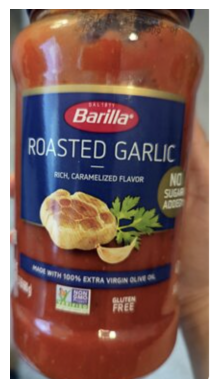

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


OCR Output: ['Barilla"', 'ROASTED GARLIC', 'RCH CARAMELIZED FLAYOR', 'No', 'S6', 'Aai', 'Fextra Virumn', 'FREE', 'm', 'Noor', '(ondo']

Detected brand: Barilla
Detected product name: Roasted Garlic

🍽️ Nutritional Facts (per 100g):
calories_100g: 36
fat_100g: 0.4
saturated_fat_100g: 0
carbs_100g: 8.8
sugars_100g: 4
fiber_100g: 2.4
protein_100g: 1.6
salt_100g: 0.82


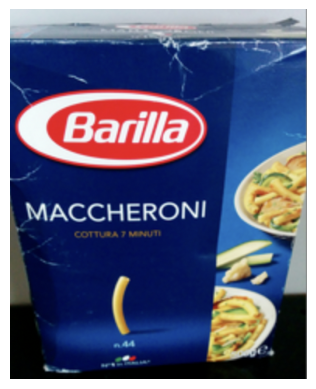

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


OCR Output: ['Barilla', 'MACCHERONI', 'conu']

Detected brand: Barilla
Detected product name: Maccheroni

🍽️ Nutritional Facts (per 100g):
calories_100g: 359
fat_100g: 2
saturated_fat_100g: 0.5
carbs_100g: 71
sugars_100g: 3.5
fiber_100g: 3
protein_100g: 13
salt_100g: 0.01


In [ ]:
process_image("/content/drive/MyDrive/foodguard/data/test/tomato sauce.png")
process_image("/content/drive/MyDrive/foodguard/data/test/pasta.png")


In [ ]:
import easyocr
import requests
import matplotlib.pyplot as plt
from PIL import Image
from difflib import get_close_matches
import re

reader = easyocr.Reader(["en"], gpu=False)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
def extract_ocr_text(img_path):
    results = reader.readtext(img_path, detail=0)
    return [t.strip() for t in results if len(t.strip()) > 0]


In [ ]:
def clean_text_list(text_list):
    cleaned = []
    for t in text_list:
        t = t.lower()
        t = re.sub(r'[^a-zA-Z ]', ' ', t)
        t = t.strip()
        if len(t) > 1:
            cleaned.append(t)
    return cleaned


In [ ]:
import re

def is_valid_word(w):
    w = w.lower()

    # alphabetic only
    if not w.isalpha():
        return False

    # too short = noise
    if len(w) < 3:
        return False

    # noise patterns like repeated letters
    if re.search(r'(.)\1{2,}', w):
        return False

    # reject weird rare letter combos
    if not re.match(r'^[a-z]+$', w):
        return False

    # Reject typical OCR garbage patterns
    garbage_patterns = [
        r'[bcdfghjklmnpqrstvwxyz]{4,}',  # long consonant clusters
        r'[aeiou]{4,}',                 # 4+ vowels in a row
    ]
    for pat in garbage_patterns:
        if re.search(pat, w):
            return False

    # reject these known OCR artifacts
    BLACKLIST = {"conu", "virumn", "noor", "aai"}
    if w in BLACKLIST:
        return False

    return True


In [ ]:
def detect_brand(ocr_text):
    if len(ocr_text) == 0:
        return None

    first = ocr_text[0].lower()
    first = re.sub(r'[^a-z]', '', first)

    return first


In [ ]:
STOPWORDS = {
    "and","with","the","made","from","rich","free","no","added",
    "premium","natural","quality","flavor","flavour","best","rich",
    "new","original","fresh","real","extra","taste","caramelized"
}

def extract_keywords(cleaned_list):
    keywords = []
    for text in cleaned_list:
        for w in text.split():
            w = w.lower()
            if w not in STOPWORDS and is_valid_word(w):
                keywords.append(w)
    return list(dict.fromkeys(keywords))



In [ ]:
def build_search_query(ocr_text):
    cleaned = clean_text_list(ocr_text)
    brand = detect_brand(ocr_text)
    keywords = extract_keywords(cleaned)

    # ensure brand first
    if brand and brand not in keywords:
        keywords.insert(0, brand)

    # openfoodfacts performs best with <=3 keywords
    keywords = keywords[:3]

    return " ".join(keywords)


In [ ]:
def search_openfoodfacts(query):
    url = "https://world.openfoodfacts.org/cgi/search.pl"
    params = {
        "search_terms": query,
        "search_simple": 1,
        "action": "process",
        "json": 1
    }
    return requests.get(url, params=params).json()


In [ ]:
def extract_nutrition(product):
    n = product.get("nutriments", {})

    return {
        "calories_100g": n.get("energy-kcal_100g"),
        "fat_100g": n.get("fat_100g"),
        "saturated_fat_100g": n.get("saturated-fat_100g"),
        "carbs_100g": n.get("carbohydrates_100g"),
        "sugars_100g": n.get("sugars_100g"),
        "fiber_100g": n.get("fiber_100g"),
        "protein_100g": n.get("proteins_100g"),
        "salt_100g": n.get("salt_100g"),
    }


In [ ]:
def process_image(img_path):
    print("Extracting OCR...")
    ocr_raw = extract_ocr_text(img_path)
    print("OCR:", ocr_raw)

    print("\n Building search query...")
    query = build_search_query(ocr_raw)
    print("Query:", query)

    print("\n Querying OpenFoodFacts...")
    data = search_openfoodfacts(query)

    if data.get("count", 0) == 0:
        print(" No products found.")
        return None

    product = data["products"][0]

    print("\n Extracting nutrition...")
    nutrition = extract_nutrition(product)

    print("\n=== NUTRITION FACTS ===")
    for k, v in nutrition.items():
        print(f"{k}: {v}")

    return nutrition


In [ ]:
process_image("/content/drive/MyDrive/foodguard/data/test/tomato sauce.png")
process_image("/content/drive/MyDrive/foodguard/data/test/pasta.png")


Extracting OCR...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


OCR: ['Barilla"', 'ROASTED GARLIC', 'RCH CARAMELIZED FLAYOR', 'No', 'S6', 'Aai', 'Fextra Virumn', 'FREE', 'm', 'Noor', '(ondo']

 Building search query...
Query: barilla roasted garlic

 Querying OpenFoodFacts...

 Extracting nutrition...

=== NUTRITION FACTS ===
calories_100g: 36
fat_100g: 0.4
saturated_fat_100g: 0
carbs_100g: 8.8
sugars_100g: 4
fiber_100g: 2.4
protein_100g: 1.6
salt_100g: 0.82
Extracting OCR...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


OCR: ['Barilla', 'MACCHERONI', 'conu']

 Building search query...
Query: barilla maccheroni

 Querying OpenFoodFacts...

 Extracting nutrition...

=== NUTRITION FACTS ===
calories_100g: 359
fat_100g: 2
saturated_fat_100g: 0.5
carbs_100g: 71
sugars_100g: 3.5
fiber_100g: 3
protein_100g: 13
salt_100g: 0.01


{'calories_100g': 359,
 'fat_100g': 2,
 'saturated_fat_100g': 0.5,
 'carbs_100g': 71,
 'sugars_100g': 3.5,
 'fiber_100g': 3,
 'protein_100g': 13,
 'salt_100g': 0.01}

In [ ]:
# BRANDS_URL = "https://world.openfoodfacts.org/data/taxonomies/brands.json"
# brands_json = requests.get(BRANDS_URL).json()

# ALL_BRANDS = set([b.lower() for b in brands_json.keys()])
# print("Loaded", len(ALL_BRANDS), "brands.")


Loaded 302 brands.
